In [10]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib as plt

In [11]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras import metrics

In [ ]:
df = pd.read_csv("../data/synthetic_dataset.csv")
TIRE_RADIUS = 0.2032

In [13]:
df.head()

,vehicle_speed,steering_angle,tire_temp,wheel_rotational_speed,wheel_rotational_acceleration,slip_ratio,is_noisy
0,30.058678,-0.028497,81.969672,151.465583,-10.681750,0.023924,0
1,20.016205,0.145625,89.673971,131.731344,100.026956,0.337307,0
2,5.510690,0.218719,23.931878,29.529967,-29.173625,0.088882,0
3,8.886849,0.093927,28.590838,59.088495,112.968775,0.351073,0
4,14.569609,-0.153367,57.901184,121.687113,65.400193,0.697151,0


In [47]:
cruising_df = df[
    (df['slip_ratio'] < 0.05) &
    (df['wheel_rotational_acceleration'].abs() < 10.0)
].copy()

teacher_df = cruising_df.sample(frac=0.5).copy()

sensor_fault_factor = np.random.uniform(0.5, 0.8, size=len(teacher_df))
teacher_df['vehicle_speed'] *= sensor_fault_factor

teacher_df['wheel_rotational_acceleration'] = np.random.normal(0, 5.0, size=len(teacher_df))

df_augmented = pd.concat([df, teacher_df], axis=0).reset_index(drop=True)
df_augmented = df_augmented.sample(frac=1).reset_index(drop=True)

In [48]:
x = df_augmented[["vehicle_speed", "steering_angle", "tire_temp" , "wheel_rotational_speed", "wheel_rotational_acceleration"]]
y = df_augmented[["slip_ratio"]]

In [49]:
print(y)

       slip_ratio
0        0.053044
1        0.097334
2        0.039057
3        0.563908
4        0.066312
...           ...
52495    0.647564
52496    0.142333
52497    0.607485
52498    0.648814
52499    0.175319

[52500 rows x 1 columns]


In [50]:
from sklearn.model_selection import train_test_split

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

In [52]:
train_data = x_train.join(y_train)
train_data.head()

,vehicle_speed,steering_angle,tire_temp,wheel_rotational_speed,wheel_rotational_acceleration,slip_ratio
50780,33.352982,0.145267,79.427785,279.684178,108.373890,0.723524
13200,15.838385,0.141948,70.095164,114.288465,97.611051,0.422396
26097,14.878557,0.198980,28.950129,74.586095,28.247522,0.025187
4889,34.313970,-0.239702,42.038092,249.746895,123.739217,0.455189
21234,21.728252,0.079011,79.678405,122.489186,3.898175,0.145504


In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

In [54]:
scaler.fit(x_train)

StandardScaler()

In [55]:
print("const int feature_count = ", len(scaler.mean_))

print("const float scaler_mean[] = {", end="")
print(*scaler.mean_, sep=', ', end="};\n")

print("const float scaler_scale[] = {", end="")
print(*scaler.scale_, sep=', ', end="};\n")

const int feature_count =  5
const float scaler_mean[] = {19.630303697626477, -0.0005450365189715463, 59.8901043966616, 120.48587937144882, 59.00885398270266};
const float scaler_scale[] = {8.66180044582203, 0.14460143717972843, 23.107923307685642, 57.82262435123635, 84.05533340078773};


In [56]:
model = models.Sequential([
    layers.Dense(24, input_shape=(5,)),
    layers.BatchNormalization(),
    layers.Activation('sigmoid'),
    layers.Dense(12),
    layers.BatchNormalization(),
    layers.Activation('sigmoid'),
    layers.Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mae',
    metrics=[metrics.MeanAbsoluteError()]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
history = model.fit(x_train_scaled, y_train, validation_data = (x_val_scaled, y_val), epochs=100, batch_size=32)

Epoch 1/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1292 - mean_absolute_error: 0.1292 - val_loss: 0.0572 - val_mean_absolute_error: 0.0572
Epoch 2/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0686 - mean_absolute_error: 0.0686 - val_loss: 0.0530 - val_mean_absolute_error: 0.0530
Epoch 3/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0636 - mean_absolute_error: 0.0636 - val_loss: 0.0448 - val_mean_absolute_error: 0.0448
Epoch 4/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0595 - mean_absolute_error: 0.0595 - val_loss: 0.0420 - val_mean_absolute_error: 0.0420
Epoch 5/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0573 - mean_absolute_error: 0.0573 - val_loss: 0.0414 - val_mean_absolute_error: 0.0414
Epoch 6/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0543 - mean_absolute_error: 0.0543 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374
Epoch 7/100
985/985 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0509 - mean_absolute_error: 0.0

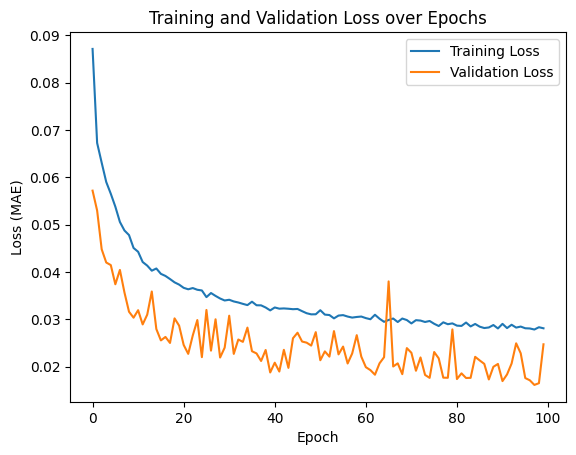

In [58]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

In [59]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 24)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24)             │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,661 (6.49 KB)

 Trainable params: 529 (2.07 KB)

 Non-trainable params: 72 (288.00 B)

 Optimizer params: 1,060 (4.14 KB)

In [60]:
model.evaluate(x_test_scaled, y_test)

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0245 - mean_absolute_error: 0.0245


[0.024294640868902206, 0.024294640868902206]

In [61]:
preds = (model.predict(x_test_scaled))

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [62]:
results_df = pd.DataFrame({'Actual Slip Ratio': y_test['slip_ratio'], 'Predicted Slip Ratio': preds.flatten()})
display(results_df)

,Actual Slip Ratio,Predicted Slip Ratio
46685,0.186388,0.202946
17859,0.291769,0.317822
7955,0.150081,0.220745
21146,0.409481,0.436124
48518,0.693082,0.718563
...,...,...
28534,0.016373,0.041543
38536,0.120634,0.132499
48731,0.024321,-0.002916
32461,0.033410,0.062928


In [63]:
results_df.describe()

,Actual Slip Ratio,Predicted Slip Ratio
count,10500.000000,10500.000000
mean,0.224446,0.243533
std,0.228795,0.231758
min,0.000040,-0.030204
25%,0.055155,0.075657
50%,0.120198,0.130096
75%,0.366956,0.401148
max,0.799872,0.825590


In [ ]:
model.save('slip_ratio_toy_model.h5')

Model saved to slip_ratio_toy_model.h5


In [ ]:
model.save('slip_ratio_toy_model.keras')

Model saved to slip_ratio_toy_model.keras


In [66]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [67]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [68]:
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpxsiynaeb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135686005897744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135686005897936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135685521163856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135685521164048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135686005886416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135685521162896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135686005898896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135686005898512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135685521164816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135685521164624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135686005898320: Tens

In [ ]:
with open('fsae_slip_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Success! Saved 'fsae_slip_model.tflite'")

Success! Saved 'fsae_slip_model.tflite'


In [ ]:
print(f"SCALER_MEAN = {scaler.mean_.tolist()}")
print(f"SCALER_SCALE = {scaler.scale_.tolist()}")

COPY THESE EXACT VALUES:
SCALER_MEAN = [19.630303697626477, -0.0005450365189715463, 59.8901043966616, 120.48587937144882, 59.00885398270266]
SCALER_SCALE = [8.66180044582203, 0.14460143717972843, 23.107923307685642, 57.82262435123635, 84.05533340078773]



Speed Sens   | Read (m/s)   | Accel    | Math Slip  | AI Slip    | Verdict
-------------------------------------------------------------------------------------
100% Health   | 25.0         | 0.0      | 0.0000     | 0.0198     | OK
95% Health   | 23.8         | 0.0      | 0.0526     | 0.0699     | OK
90% Health   | 22.5         | 0.0      | 0.1111     | 0.1250     | OK
85% Health   | 21.2         | 0.0      | 0.1765     | 0.1518     | AI FAILED
80% Health   | 20.0         | 0.0      | 0.2500     | 0.1137     | AI SAVED CAR
75% Health   | 18.8         | 0.0      | 0.3333     | 0.0369     | AI SAVED CAR
70% Health   | 17.5         | 0.0      | 0.4286     | 0.0043     | AI SAVED CAR


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


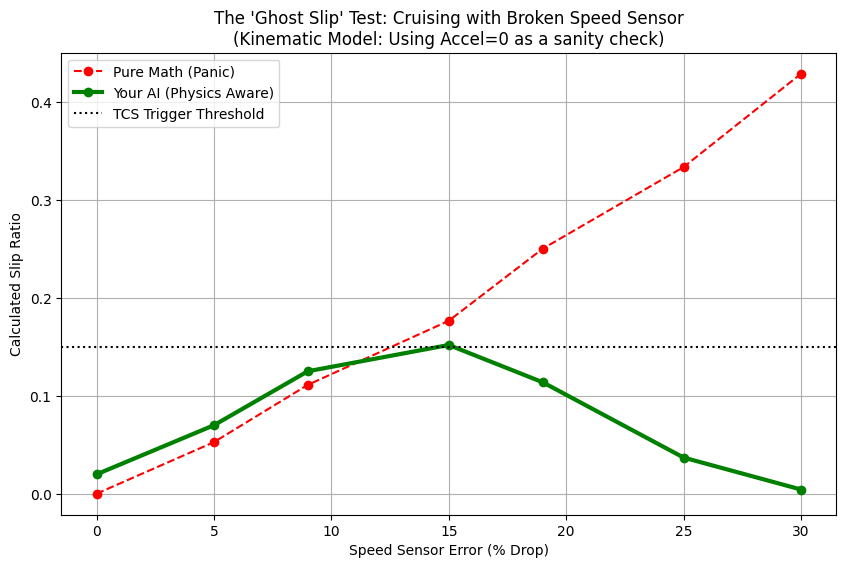

In [ ]:
# check to ensure model is not acting as a calculator

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
TIRE_RADIUS = 0.2032
MODEL_FILE = "fsae_slip_model.tflite" # Name of your converted model

SCALER_MEAN = [19.630303697626477, -0.0005450365189715463, 59.8901043966616, 120.48587937144882, 59.00885398270266]
SCALER_SCALE = [8.66180044582203, 0.14460143717972843, 23.107923307685642, 57.82262435123635, 84.05533340078773]

# --- 2. LOAD TFLITE MODEL ---
interpreter = tf.lite.Interpreter(model_path=MODEL_FILE)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_idx = input_details[0]['index']
output_idx = output_details[0]['index']

def predict_kinematic_slip(v, steer, temp, w, alpha):
    # 1. Prepare Features (Order is Critical!)
    # Must match: [vehicle_speed, steering_angle, tire_temp, wheel_rotational_speed, wheel_rotational_acceleration]
    raw_vector = np.array([v, steer, temp, w, alpha])

    # 2. Scale
    scaled_vector = (raw_vector - SCALER_MEAN) / SCALER_SCALE

    # 3. Inference
    input_tensor = np.array([scaled_vector], dtype=np.float32)
    interpreter.set_tensor(input_idx, input_tensor)
    interpreter.invoke()
    return interpreter.get_tensor(output_idx)[0][0]

# --- 3. THE "GHOST SLIP" TEST ---
# Scenario: Cruising at 25m/s. Speed Sensor starts failing.
print(f"\n{'Speed Sens':<12} | {'Read (m/s)':<12} | {'Accel':<8} | {'Math Slip':<10} | {'AI Slip':<10} | {'Verdict'}")
print("-" * 85)

# Constants for Cruising
v_true = 25.0
w_true = v_true / TIRE_RADIUS  # Wheel spinning at correct speed (No slip)
alpha_input = 0.0              # CRITICAL: We are NOT accelerating
steer_input = 0.0
temp_input = 60.0

math_plot = []
ai_plot = []
errors_plot = []

# Simulate Sensor Drop from 100% health to 70% health
sensor_health = [1.0, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70]

for health in sensor_health:
    # 1. Corrupt the Sensor
    v_reading = v_true * health

    # 2. Pure Math Calculation (The Dumb Way)
    # Formula: (Wheel Speed / Vehicle Speed) - 1
    math_slip = (w_true * TIRE_RADIUS / v_reading) - 1

    # 3. AI Prediction (The Smart Way)
    # We feed it the WRONG speed, but the CORRECT (Zero) Acceleration
    ai_slip = predict_kinematic_slip(v_reading, steer_input, temp_input, w_true, alpha_input)

    # 4. Verdict
    # If Math says > 0.15 (Spin) but AI says < 0.15 (Safe), the AI is using context.
    if math_slip > 0.15 and ai_slip < 0.15:
        verdict = "AI SAVED CAR"
    elif math_slip > 0.15 and ai_slip > 0.15:
        verdict = "AI FAILED"
    else:
        verdict = "OK"

    print(f"{int(health*100)}% Health   | {v_reading:<12.1f} | {alpha_input:<8.1f} | {math_slip:<10.4f} | {ai_slip:<10.4f} | {verdict}")

    math_plot.append(math_slip)
    ai_plot.append(ai_slip)
    errors_plot.append(int((1-health)*100))

# --- 4. VISUAL PROOF ---
plt.figure(figsize=(10, 6))
plt.plot(errors_plot, math_plot, 'r--o', label="Pure Math (Panic)")
plt.plot(errors_plot, ai_plot, 'g-o', linewidth=3, label="Your AI (Physics Aware)")
plt.axhline(y=0.15, color='k', linestyle=':', label="TCS Trigger Threshold")
plt.title("The 'Ghost Slip' Test: Cruising with Broken Speed Sensor\n(Kinematic Model: Using Accel=0 as a sanity check)")
plt.xlabel("Speed Sensor Error (% Drop)")
plt.ylabel("Calculated Slip Ratio")
plt.legend()
plt.grid(True)
plt.show()

Running predictions on test set...
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Absolute Error: 0.02429


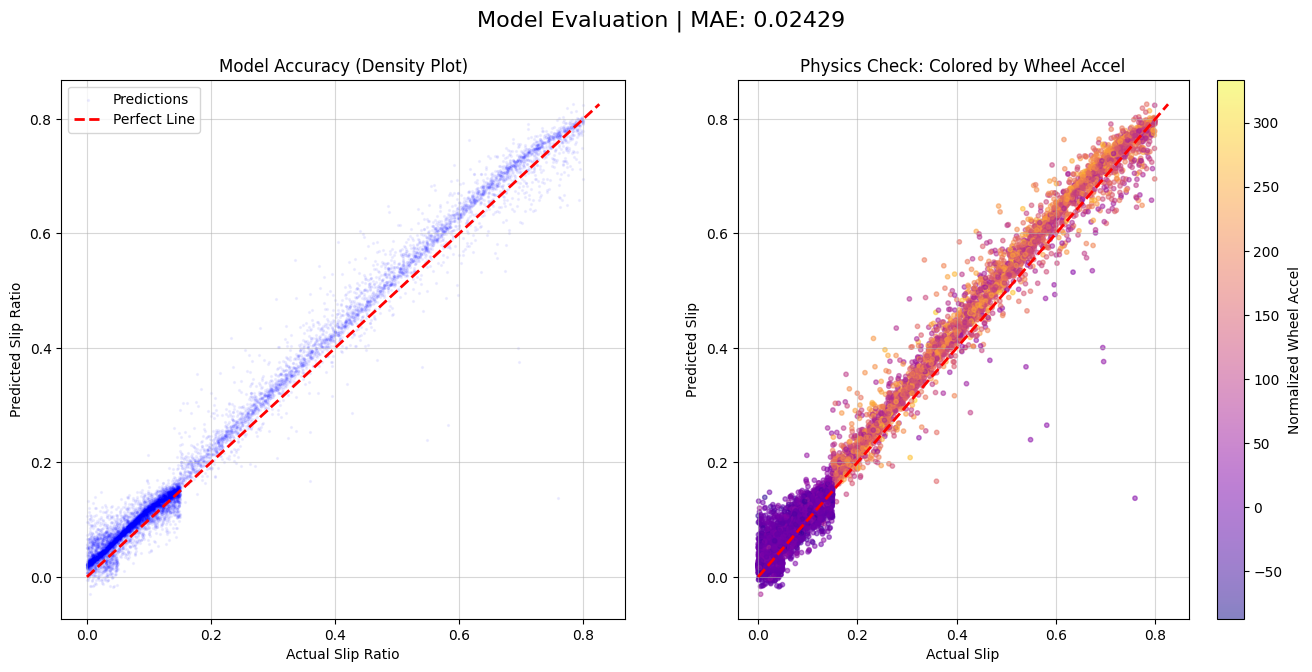

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

def visualize_performance(model, x_test, y_test, feature_name="Wheel Acceleration", feature_idx=4):
    """
    Generates a 2-panel plot:
    Left: Accuracy Cloud (Blue)
    Right: Physics Check (Colored by a specific feature)
    """

    # 1. Run Predictions
    print("Running predictions on test set...")
    y_pred = model.predict(x_test_scaled).flatten()

    # 2. Calculate Error Stats
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error: {mae:.5f}")

    # 3. Setup the Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # --- PLOT 1: MODEL ACCURACY (Left) ---
    # We use very high transparency (alpha=0.05) to visualize density
    ax1.scatter(y_test, y_pred, alpha=0.05, s=2, color='blue', label='Predictions')

    # The "Perfect Prediction" Line (y=x)
    max_val = max(np.max(y_test), np.max(y_pred))
    ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Line')

    ax1.set_title("Model Accuracy (Density Plot)")
    ax1.set_xlabel("Actual Slip Ratio")
    ax1.set_ylabel("Predicted Slip Ratio")
    ax1.legend()
    ax1.grid(True, alpha=0.5)

    # --- PLOT 2: PHYSICS CHECK (Right) ---
    # We color the dots based on the "Physics Feature" (e.g., Acceleration)
    # This helps you see if the model struggles in specific conditions (e.g. High Accel)

    # Extract the feature column for coloring
    # (Assuming X_test is a Numpy array or Pandas DataFrame)
    if hasattr(x_test, 'iloc'):
        color_data = x_test.iloc[:, feature_idx] # Pandas
    else:
        color_data = x_test[:, feature_idx] # Numpy

    sc = ax2.scatter(y_test, y_pred, c=color_data, cmap='plasma', alpha=0.5, s=10)

    # Perfect Line again
    ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2)

    # Colorbar
    cbar = plt.colorbar(sc, ax=ax2)
    cbar.set_label(f"Normalized {feature_name}")

    ax2.set_title(f"Physics Check: Colored by {feature_name}")
    ax2.set_xlabel("Actual Slip")
    ax2.set_ylabel("Predicted Slip")
    ax2.grid(True, alpha=0.5)

    # Super Title
    plt.suptitle(f"Model Evaluation | MAE: {mae:.5f}", fontsize=16)
    plt.show()

# --- EXECUTE ---
# Feature Index 4 is 'wheel_rotational_acceleration' in your 5-feature list
visualize_performance(model, x_test, y_test, feature_name="Wheel Accel", feature_idx=4)